In [6]:
# prep: import modules and get pwd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [49]:
#Create a query or queries to extract the information you think may be relevant for building the prediction model. 
#It should include some film features and some rental features. Use the data from 2005.
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''select r.rental_date, f.film_id as id,f.length, f.rating  from film f join rental r
where rental_date >= "2005/01/01"
and rental_date <= "2005/12/31/";;'''

data = pd.read_sql_query(query, engine)
data.head()

,rental_date,id,length,rating
0,2005-05-24 22:53:30,1000,50,NC-17
1,2005-05-24 22:53:30,999,101,R
2,2005-05-24 22:53:30,998,105,NC-17
3,2005-05-24 22:53:30,997,179,NC-17
4,2005-05-24 22:53:30,996,183,G


In [8]:
# I planned on using release_year, but all films were supposedly released on 2006, so there will be no differential effect

In [9]:
#Create a query to get the total amount of rentals in June for each film.

In [46]:
query = '''select f.film_id as id, sum( f.film_id) as rentals_june from film f join rental r
WHERE MONTH(r.rental_date) =6 
group by id;'''

june = pd.read_sql_query(query, engine)
june.head()

,id,rentals_june
0,1000,2311000.0
1,999,2308689.0
2,998,2306378.0
3,997,2304067.0
4,996,2301756.0


In [11]:
# Do the same with July.

In [13]:
query = '''select f.film_id as id, sum( f.film_id) as rentals_june from film f join rental r
WHERE MONTH(r.rental_date) =7 
group by id;'''

july = pd.read_sql_query(query, engine)
july.head()

,id,rentals_july
0,1000,6030000.0
1,999,6023970.0
2,998,6017940.0
3,997,6011910.0
4,996,6005880.0


In [14]:
# Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger 
# than in June. Your objective will be to predict this new column.

In [50]:
# Firstly, I merge both tables so that I can make the comparison in the new column.
merged = pd.merge(june, july, on='id', how='outer')
merged.head()

,id,rentals_june,rentals_july
0,1000,2311000.0,6030000.0
1,999,2308689.0,6023970.0
2,998,2306378.0,6017940.0
3,997,2304067.0,6011910.0
4,996,2301756.0,6005880.0


In [51]:
merged['july>june'] = np.where(merged["rentals_july"] < merged["rentals_june"] , "no", "yes")
merged.head()

,id,rentals_june,rentals_july,july>june
0,1000,2311000.0,6030000.0,yes
1,999,2308689.0,6023970.0,yes
2,998,2306378.0,6017940.0,yes
3,997,2304067.0,6011910.0,yes
4,996,2301756.0,6005880.0,yes


In [56]:
file = pd.merge(data, merged, on='id', how='left')
file.head()



,rental_date,id,length,rating,rentals_june,rentals_july,july>june
0,2005-05-24 22:53:30,1000,50,NC-17,2311000.0,6030000.0,yes
1,2005-05-24 22:53:30,999,101,R,2308689.0,6023970.0,yes
2,2005-05-24 22:53:30,998,105,NC-17,2306378.0,6017940.0,yes
3,2005-05-24 22:53:30,997,179,NC-17,2304067.0,6011910.0,yes
4,2005-05-24 22:53:30,996,183,G,2301756.0,6005880.0,yes


In [18]:
# Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables

In [57]:
numerics = ['integer', 'float']

numerical = file.select_dtypes(include=numerics).copy()

#id is a variable that will have no impact on the dependent variable, so I drop it

numerical =  numerical.drop(["id"],axis=1)
numerical.head()

,length,rentals_june,rentals_july
0,50,2311000.0,6030000.0
1,101,2308689.0,6023970.0
2,105,2306378.0,6017940.0
3,179,2304067.0,6011910.0
4,183,2301756.0,6005880.0


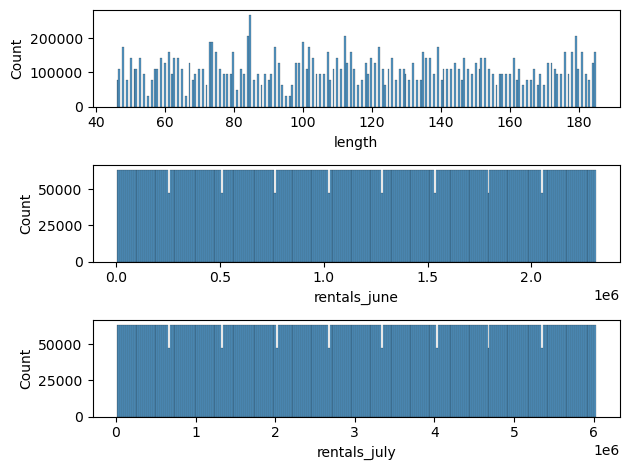

In [20]:
#Use Matplotlib to construct histograms
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
fig, axes = plt.subplots(3)
sns.histplot(data=numerical, x='length', ax=axes[0])
sns.histplot(data=numerical, x='rentals_june', ax=axes[1])
sns.histplot(data=numerical, x='rentals_july', ax=axes[2])


plt.tight_layout()
plt.show()
#Do the distributions for different numerical variables look like a normal distribution


<AxesSubplot:>

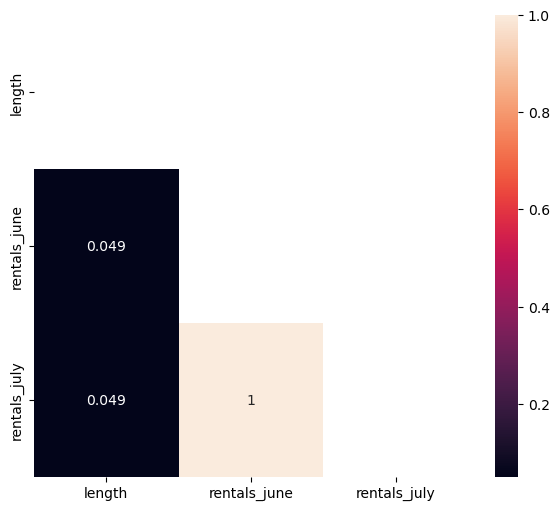

In [21]:
subjective_corr = numerical.corr()
#subjective_corr[np.abs(subjective_corr)<.3] = 0
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(numerical.corr(), dtype=bool))

sns.heatmap(subjective_corr, annot=True, mask=mask)

In [58]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = file['july>june']
X = file.drop('july>june', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [59]:
X_train_num=X_train[["length"]]
X_train_num

,length
5282563,109
12747069,48
1904948,173
4284045,135
2103237,75
...,...
3589440,62
10318351,85
5242852,132
8100989,126


In [60]:
#For categorical variables
X_train_categorical = X_train.select_dtypes("object")
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
5282563,0,0,0,1
12747069,0,0,1,0
1904948,0,0,0,0
4284045,0,1,0,0
2103237,0,0,0,0


In [61]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_num, X_train_cat], axis=1)


In [31]:
from sklearn.linear_model import LogisticRegression

In [62]:
classification = LogisticRegression(random_state=10,solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'yes'

In [ ]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

In [ ]:
print(y_test.value_counts())
# As you would notice here, there is a huge imbalance in the data among the different classes. 
# We will talk more about imbalance and how to resolve it later (tomorrow)


In [ ]:
pd.Series(predictions).value_counts()
# This shows that the disparity in the numbers are amplified by the model

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)